In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import math
import nltk

# Importing required libraries
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers


c:\Users\bill\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bill\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\bill\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# list讀取
# tfidf
import numpy as np
a=np.load('np_monofakewords_tfidf.npy',allow_pickle=True)
a=a.tolist()
monofakewords_tfidf_f=list(a)

a=np.load('np_nmfakewords_tfidf.npy',allow_pickle=True)
a=a.tolist()
nmfakewords_tfidf_f=list(a)

a=np.load('np_antifakewords_tfidf.npy',allow_pickle=True)
a=a.tolist()
antifakewords_tfidf_f=list(a)

#
a=np.load('np_monofakewords_truereview_tfidf.npy',allow_pickle=True)
a=a.tolist()
monofakewords_tfidf_t=list(a)

a=np.load('np_nmfakewords_truereview_tfidf.npy',allow_pickle=True)
a=a.tolist()
nmfakewords_tfidf_t=list(a)

a=np.load('np_antifakewords_truereview_tfidf.npy',allow_pickle=True)
a=a.tolist()
antifakewords_tfidf_t=list(a)
del a

In [3]:
# 資料集平衡 # TFIDF
bal_monofakewords_tfidf_f = monofakewords_tfidf_f+monofakewords_tfidf_f+monofakewords_tfidf_f+monofakewords_tfidf_f+monofakewords_tfidf_f+monofakewords_tfidf_f+monofakewords_tfidf_f
bal_antifakewords_tfidf_f = antifakewords_tfidf_f+antifakewords_tfidf_f+antifakewords_tfidf_f+antifakewords_tfidf_f+antifakewords_tfidf_f+antifakewords_tfidf_f+antifakewords_tfidf_f
bal_nmfakewords_tfidf_f = nmfakewords_tfidf_f+nmfakewords_tfidf_f+nmfakewords_tfidf_f+nmfakewords_tfidf_f+nmfakewords_tfidf_f+nmfakewords_tfidf_f+nmfakewords_tfidf_f
print("真評論篇數: ", len(monofakewords_tfidf_t))
print("bal假評論篇數: ", len(bal_monofakewords_tfidf_f))
# bal = balanced

# concate list 分成 mono 和 non mono
dataset_mono = bal_monofakewords_tfidf_f + monofakewords_tfidf_t
dataset_anti = bal_antifakewords_tfidf_f + antifakewords_tfidf_t
dataset_nm = bal_nmfakewords_tfidf_f + nmfakewords_tfidf_t

print("mono評論篇數: ", len(dataset_mono))
print("anti評論篇數: ", len(dataset_anti))
print("nm評論篇數: ", len(dataset_nm))

# 轉為標準矩陣 用以後續分割
dataset_mono = np.array(dataset_mono)
dataset_anti = np.array(dataset_anti)
dataset_nm = np.array(dataset_nm)

真評論篇數:  58642
bal假評論篇數:  58373
mono評論篇數:  117015
anti評論篇數:  117015
nm評論篇數:  117015


In [4]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load pima indians dataset
# dataset_mono -> 3 feature + 1 flagged
# dataset_nm -> 27 feature + 1 flagged

# 先進行shuffle 再切割
#np.random.shuffle(dataset_mono)
#np.random.shuffle(dataset_nm)
'''
indices_mono = np.arange(dataset_mono.shape[0])
indices_nm = np.arange(dataset_nm.shape[0])
np.random.shuffle(indices_mono)
np.random.shuffle(indices_nm)
dataset_mono = dataset_mono[indices_mono]
dataset_nm = dataset_nm[indices_nm]
'''
# split into input (X) and output (Y) variables
X_mono = dataset_mono[:,0:-1]
Y_mono = dataset_mono[:,-1] # Y_mono 與 Y_anti 相等
X_anti = dataset_anti[:,0:-1]
Y_anti = dataset_anti[:,-1]
X_nm = dataset_nm[:,0:-1]
Y_nm = dataset_nm[:,-1]

X_mono = np.array(X_mono)
X_anti = np.array(X_anti)
X_nm = np.array(X_nm)
Y_mono = np.array(Y_mono)
Y_anti = np.array(Y_anti)
Y_nm = np.array(Y_nm)
X_monoanti = np.concatenate([X_mono, X_anti], axis=1)
print(X_mono.shape)
print(X_anti.shape)
print(X_monoanti.shape)
print(X_nm.shape)

(117015, 330)
(117015, 375)
(117015, 705)
(117015, 1295)


## Model

In [5]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Add
from CustomConstraints import Custom_kernelinit
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

# 500 mono 93 nm 407
# 200 44 156
# 100 

In [6]:
# Compile model
from CustomOPt import Custom
import tensorflow.keras as keras
opt = Custom(lr=0.001, beta_1=0.5, beta_2=0.999)

input_shape_monoanti = X_monoanti.shape[1]
input_shape_nm = X_nm.shape[1]

# first input model
visible1 = Input(shape=(input_shape_monoanti,))
#dense_m1 = Dense(1024, activation='sigmoid', kernel_constraint=keras.constraints.MinMaxNorm(min_value=0.01, max_value=1.0, rate=1.0, axis=0))(visible1)
dense_m1 = Dense(1024, activation='sigmoid', kernel_constraint=Custom_kernelinit(min_value=0.01, max_value=1.0, rate=1.0, axis=0))(visible1)
dense_m1 = Dropout(0.2)(dense_m1)
dense_m1 = BatchNormalization()(dense_m1)

dense_m1 = Dense(512, activation='sigmoid', kernel_constraint=Custom_kernelinit(min_value=0.01, max_value=1.0, rate=1.0, axis=0))(dense_m1)
dense_m1 = Dropout(0.2)(dense_m1)
dense_m1 = BatchNormalization()(dense_m1)

dense_m1 = Dense(256, activation='sigmoid', kernel_constraint=Custom_kernelinit(min_value=0.01, max_value=1.0, rate=1.0, axis=0))(dense_m1)
dense_m1 = Dropout(0.2)(dense_m1)
dense_m1 = BatchNormalization()(dense_m1)
flat1 = Flatten()(dense_m1)

m1 = Model(inputs=visible1, outputs=flat1)
m1.compile(optimizer=opt)

# second input model
visible2 = Input(shape=(input_shape_nm,))
dense_nm1 = Dense(1024, activation='relu')(visible2)
dense_nm1 = Dropout(0.2)(dense_nm1)
dense_nm1 = BatchNormalization()(dense_nm1)

dense_nm1 = Dense(512, activation='relu')(dense_nm1)
dense_nm1 = Dropout(0.2)(dense_nm1)
dense_nm1 = BatchNormalization()(dense_nm1)

dense_nm1 = Dense(256, activation='relu')(dense_nm1)
dense_nm1 = Dropout(0.2)(dense_nm1)
dense_nm1 = BatchNormalization()(dense_nm1)
flat2 = Flatten()(dense_nm1)

m2 = Model(inputs=visible2, outputs=flat2)
m2.compile(optimizer='Adam')

# merge input models
merge = Add()([m1.output, m2.output])
# interpretation model
hidden1 = Dense(128, activation='relu')(merge)
hidden1 = Dropout(0.2)(hidden1)
hidden1 = BatchNormalization()(hidden1)
hidden1 = Dense(64, activation='relu')(hidden1)
hidden1 = Dropout(0.2)(hidden1)
hidden1 = BatchNormalization()(hidden1)
output = Dense(1, activation='sigmoid')(hidden1)

model = Model(inputs=[m1.input, m2.input], outputs=output)

# glorot: 128->256 => 0.125 => / 20up

In [7]:
# summarize layers
#print(model.summary())

In [8]:
# plot graph
#plot_model(model, to_file='multiple_inputs.png')

In [9]:
# 如果model跑不動可以跑這個試試
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="True"

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_monoanti, Y_mono, test_size=0.2, random_state=87)
X_train_nm, X_test_nm, Y_train_nm, Y_test_nm = train_test_split(X_nm, Y_nm, test_size=0.2, random_state=87)

In [11]:
# Compile model
from CustomOPt import Custom
opt = Custom(lr=0.001, beta_1=0.75, beta_2=0.999)

model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
# Fit the model
history = model.fit([X_train, X_train_nm], Y_train, validation_split=0.2, epochs=200, batch_size=256, verbose=2, shuffle=True) # list all data in history
# verbose：日志展示，整数 0 :为不在标准输出流输出日志信息 1 :显示进度条 2 :每个epoch输出一行记录

print(history.history.keys())

Epoch 1/200
293/293 - 20s - loss: 0.6943 - accuracy: 0.5881 - val_loss: 0.6606 - val_accuracy: 0.5995
Epoch 2/200
293/293 - 3s - loss: 0.5947 - accuracy: 0.6781 - val_loss: 0.5369 - val_accuracy: 0.7198
Epoch 3/200
293/293 - 3s - loss: 0.4521 - accuracy: 0.7840 - val_loss: 0.3950 - val_accuracy: 0.8146
Epoch 4/200
293/293 - 3s - loss: 0.3275 - accuracy: 0.8541 - val_loss: 0.3416 - val_accuracy: 0.8505
Epoch 5/200
293/293 - 3s - loss: 0.2498 - accuracy: 0.8926 - val_loss: 0.2972 - val_accuracy: 0.8705
Epoch 6/200
293/293 - 3s - loss: 0.2045 - accuracy: 0.9144 - val_loss: 0.2729 - val_accuracy: 0.8835
Epoch 7/200
293/293 - 3s - loss: 0.1751 - accuracy: 0.9273 - val_loss: 0.2497 - val_accuracy: 0.8993
Epoch 8/200
293/293 - 3s - loss: 0.1559 - accuracy: 0.9341 - val_loss: 0.2390 - val_accuracy: 0.9057
Epoch 9/200
293/293 - 3s - loss: 0.1391 - accuracy: 0.9423 - val_loss: 0.3140 - val_accuracy: 0.8839
Epoch 10/200
293/293 - 3s - loss: 0.1295 - accuracy: 0.9468 - val_loss: 0.2273 - val_accur

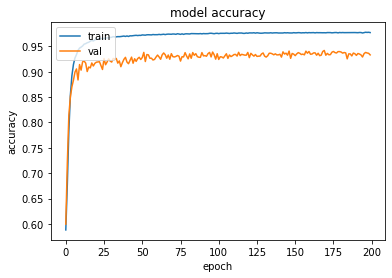

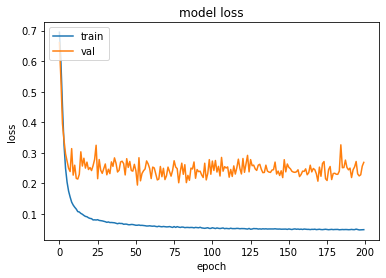

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

## Model Performance

In [13]:
# val 分類比例
c = 0
d = 0
for i in Y_test:
    if (i==1) :
        c =c+1
    if (i==0) :
        d =d+1
print("val中(N,true,1)評論數:",c)
print("val中(Y,fake,0)評論數:",d)

y_pred = model.predict([X_test, X_test_nm]) # Y predict
y_pred_original = y_pred
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_pred)): 
    if Y_test[i]==y_pred[i]==1:
        TP += 1
    if y_pred[i]==1 and Y_test[i]!=y_pred[i]:
        FP += 1
    if Y_test[i]==y_pred[i]==0:
        TN += 1
    if y_pred[i]==0 and Y_test[i]!=y_pred[i]:
        FN += 1
        
print("TP reviews:",TP)
print("FP reviews:",FP)
print("TN reviews:",TN)
print("FN reviews:",FN)

Acc = (TP+TN)/(TP+ FN+FP+TN)
Pre = (TP)/(TP+FP)
Recall = TP / (TP+FN)
F1 = 2*((Recall*Pre)/(Recall+Pre))
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("Accuracy: ", Acc)
print("Precison: ", Pre)
print("Recall: ", Recall)
print("F1-measure: ", F1)
print(X_mono.shape)
print(X_anti.shape)
print(X_nm.shape)

val中(N,true,1)評論數: 11609
val中(Y,fake,0)評論數: 11794
TP reviews: 10173
FP reviews: 62
TN reviews: 11732
FN reviews: 1436
Accuracy:  0.9359911122505662
Precison:  0.993942354665364
Recall:  0.8763028684641226
F1-measure:  0.9314228163340048
(117015, 330)
(117015, 375)
(117015, 1295)


AUC:  0.9355229790853766


<Figure size 432x288 with 0 Axes>

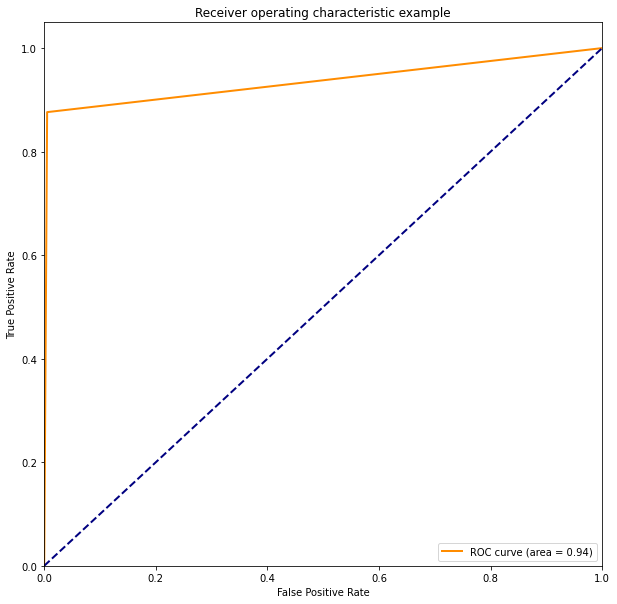

In [14]:
from sklearn.metrics import roc_curve, auc  ###計算roc和auc

fpr,tpr,threshold = roc_curve(Y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print("AUC: ",roc_auc)
plt.show()

In [15]:
X_test.shape

(23403, 705)

In [16]:
import math
# Cn取m
n = 23403
m = 2
print(math.factorial(n)//(math.factorial(m)*math.factorial(n-m)))

273838503


In [17]:
X_mono.shape[1]

330

In [18]:
# 將 X_test 分成 mono的feature和anti的feature 並加總 變成一個 (n,2)的shape
import math
X_test_mono = X_test[:,0:X_mono.shape[1]]
X_test_anti = X_test[:,X_mono.shape[1]:]
# X_test_nm
X_test_sum = []
aaa =[]
for review in range(len(X_test)):
    sum_mono = np.sum(X_test_mono, axis=1)[review]
    sum_anti = np.sum(X_test_anti, axis=1)[review]
    aaa.append(sum_mono)
    aaa.append(sum_anti)
    X_test_sum.append(aaa)
    aaa = []
    
print(len(X_test_sum))

23403


In [19]:
# FMR = FM / P
# 分別對 X_test 和 X_test_nm 檢查 X1~Xn 的不違反單調性的pair數 以及全部數
import math
length = len(X_test) ## 這裡應該對Xmono+Xnm吧? 好像不是 只需mono和anti
FM = []
# 先對mono
all_num_mono = 0 # 越大 越fake(y越小)
all_num_anti = 0 # 越大 越true(y越大)
for i in range(0, length): # 兩兩相比
    for j in range(i+1, length):
        if X_test_sum[i][0] >= X_test_sum[j][0]:
            if y_pred_original[i] <= y_pred_original[j]:
                all_num_mono = all_num_mono + 1
        else:
            if y_pred_original[i] >= y_pred_original[j]:
                all_num_mono = all_num_mono + 1
# 再對anti
for i in range(0, length): # 兩兩相比
    for j in range(i+1, length):
        if X_test_sum[i][1] >= X_test_sum[j][1]:
            if y_pred_original[i] >= y_pred_original[j]:
                all_num_anti = all_num_anti + 1
        else:
            if y_pred_original[i] <= y_pred_original[j]:
                all_num_anti = all_num_anti + 1

FM = (all_num_mono + all_num_anti)/2
print(all_num_mono)
print(all_num_anti)
print(FM)

204621833
232944588
218783210.5


In [20]:
n = length
m = 2
P = math.factorial(n)//(math.factorial(m)*math.factorial(n-m))
FMR = FM/P
FMR

0.7989497755178716

In [21]:
y_pred_original

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

## Model1 for Compare

In [22]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="True"

In [23]:
X_mono = np.array(X_mono)
X_anti = np.array(X_anti)
X_nm = np.array(X_nm)
Y_mono = np.array(Y_mono)
Y_anti = np.array(Y_anti)
Y_nm = np.array(Y_nm)

X_all = np.concatenate([X_monoanti,X_nm],axis=1)

print(np.shape(X_mono))
print(np.shape(X_anti))
print(np.shape(X_nm))
print(np.shape(X_all))
print(np.shape(Y_mono))

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_mono, test_size=0.2, random_state=87)

(117015, 330)
(117015, 375)
(117015, 1295)
(117015, 2000)
(117015,)


In [24]:
# Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from CustomConstraints import Custom_kernelinit
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

input_shape = X_train.shape[1]

# first input model
visible = Input(shape=(input_shape,))
hidden = Dense(256, activation='relu', kernel_initializer='glorot_normal' , bias_initializer='normal' )(visible)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)

hidden = Dense(128, activation='relu', kernel_initializer='glorot_normal' , bias_initializer='normal' )(hidden)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)

output = Dense(1, activation='sigmoid')(hidden)

model1 = Model(inputs=visible, outputs=output)

In [25]:
# first input model
# 如果改成全部指數化??
# Compile model
'''
from CustomOPt import Custom
import tensorflow.keras as keras
opt = Custom(lr=0.001, beta_1=0.5, beta_2=0.999)

# Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from CustomConstraints import Custom_kernelinit
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

input_shape = X_train.shape[1]
visible = Input(shape=(input_shape,))
hidden = Dense(256, activation='sigmoid', kernel_constraint=keras.constraints.MinMaxNorm(min_value=0.01, max_value=1.0, rate=1.0, axis=0),
               kernel_initializer='glorot_normal' , bias_initializer='normal' )(visible)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)

hidden = Dense(128, activation='sigmoid', kernel_constraint=keras.constraints.MinMaxNorm(min_value=0.01, max_value=1.0, rate=1.0, axis=0),
               kernel_initializer='glorot_normal' , bias_initializer='normal' )(hidden)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)

output = Dense(1, activation='sigmoid')(hidden)

model1 = Model(inputs=visible, outputs=output)
'''
# 爛的跟屎一樣

"\nfrom CustomOPt import Custom\nimport tensorflow.keras as keras\nopt = Custom(lr=0.001, beta_1=0.5, beta_2=0.999)\n\n# Inputs\nfrom keras.utils import plot_model\nfrom keras.models import Model\nfrom keras.layers import Input\nfrom keras.layers import Dense\nfrom keras.layers import Flatten\nfrom keras.layers import BatchNormalization\nfrom keras.layers.convolutional import Conv2D\nfrom keras.layers.pooling import MaxPooling2D\nfrom keras.layers.merge import concatenate\nfrom CustomConstraints import Custom_kernelinit\nimport tensorflow as tf\ntf.compat.v1.enable_eager_execution()\n\ninput_shape = X_train.shape[1]\nvisible = Input(shape=(input_shape,))\nhidden = Dense(256, activation='sigmoid', kernel_constraint=keras.constraints.MinMaxNorm(min_value=0.01, max_value=1.0, rate=1.0, axis=0),\n               kernel_initializer='glorot_normal' , bias_initializer='normal' )(visible)\nhidden = Dropout(0.2)(hidden)\nhidden = BatchNormalization()(hidden)\n\nhidden = Dense(128, activation='si

In [26]:
# Compile model 1 
from CustomOPt import Custom
#opt = Custom(lr=0.01, beta_1=0.2, beta_2=0.8)

model1.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])
# Fit the model
history1 = model1.fit(X_train, Y_train, validation_split=0.2, epochs=50, batch_size=256, verbose=2,shuffle=True) # list all data in history
# verbose：日志展示，整数 0 :为不在标准输出流输出日志信息 1 :显示进度条 2 :每个epoch输出一行记录

print(history1.history.keys())

Epoch 1/50
293/293 - 2s - loss: 0.6526 - accuracy: 0.6404 - val_loss: 0.5709 - val_accuracy: 0.7114
Epoch 2/50
293/293 - 1s - loss: 0.5248 - accuracy: 0.7346 - val_loss: 0.4712 - val_accuracy: 0.7837
Epoch 3/50
293/293 - 1s - loss: 0.4141 - accuracy: 0.8082 - val_loss: 0.3697 - val_accuracy: 0.8404
Epoch 4/50
293/293 - 1s - loss: 0.3221 - accuracy: 0.8600 - val_loss: 0.3121 - val_accuracy: 0.8705
Epoch 5/50
293/293 - 1s - loss: 0.2563 - accuracy: 0.8917 - val_loss: 0.2772 - val_accuracy: 0.8848
Epoch 6/50
293/293 - 1s - loss: 0.2114 - accuracy: 0.9130 - val_loss: 0.2463 - val_accuracy: 0.9024
Epoch 7/50
293/293 - 1s - loss: 0.1792 - accuracy: 0.9279 - val_loss: 0.2378 - val_accuracy: 0.9064
Epoch 8/50
293/293 - 1s - loss: 0.1563 - accuracy: 0.9372 - val_loss: 0.2222 - val_accuracy: 0.9171
Epoch 9/50
293/293 - 1s - loss: 0.1366 - accuracy: 0.9464 - val_loss: 0.2191 - val_accuracy: 0.9166
Epoch 10/50
293/293 - 1s - loss: 0.1281 - accuracy: 0.9497 - val_loss: 0.2186 - val_accuracy: 0.9189

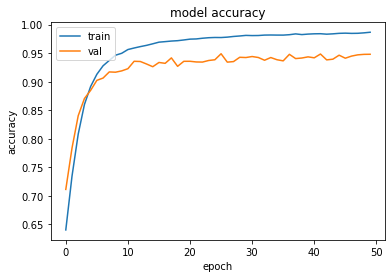

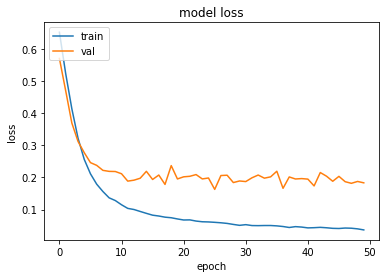

In [27]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history1.history['loss']) 
plt.plot(history1.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

## Model1 Performance

In [28]:
# val 分類比例
c = 0
d = 0
for i in Y_test:
    if (i==1) :
        c =c+1
    if (i==0) :
        d =d+1
print("val中(N,true,1)評論數:",c)
print("val中(Y,fake,0)評論數:",d)

y_pred = model1.predict(X_test) # Y predict
y_pred_original = y_pred
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_pred)): 
    if Y_test[i]==y_pred[i]==1:
        TP += 1
    if y_pred[i]==1 and Y_test[i]!=y_pred[i]:
        FP += 1
    if Y_test[i]==y_pred[i]==0:
        TN += 1
    if y_pred[i]==0 and Y_test[i]!=y_pred[i]:
        FN += 1
        
print("TP reviews:",TP)
print("FP reviews:",FP)
print("TN reviews:",TN)
print("FN reviews:",FN)

Acc = (TP+TN)/(TP+ FN+FP+TN)
Pre = (TP)/(TP+FP)
Recall = TP / (TP+FN)
F1 = 2*((Recall*Pre)/(Recall+Pre))
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("Accuracy: ", Acc)
print("Precison: ", Pre)
print("Recall: ", Recall)
print("F1-measure: ", F1)

val中(N,true,1)評論數: 11609
val中(Y,fake,0)評論數: 11794
TP reviews: 10412
FP reviews: 75
TN reviews: 11719
FN reviews: 1197
Accuracy:  0.9456479938469426
Precison:  0.9928482883570134
Recall:  0.8968903436988543
F1-measure:  0.94243301955105


AUC:  0.9452655890106956


<Figure size 432x288 with 0 Axes>

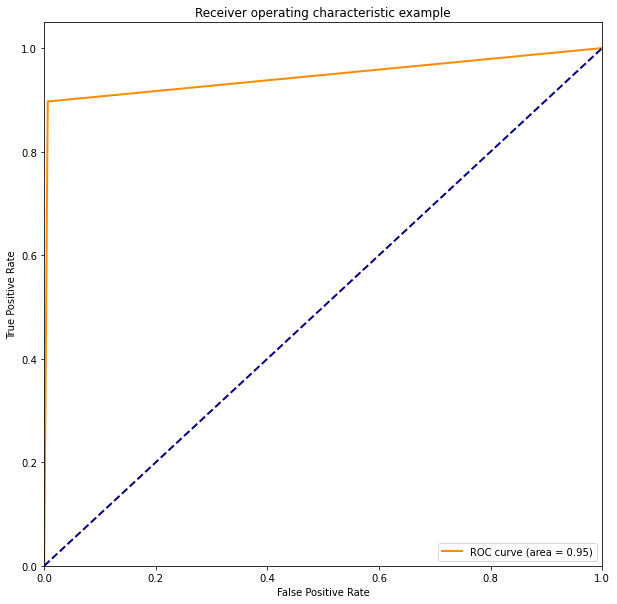

In [29]:
from sklearn.metrics import roc_curve, auc  ###計算roc和auc

fpr,tpr,threshold = roc_curve(Y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print("AUC: ",roc_auc)
plt.show()

In [30]:
# 將 X_test 分成 mono的feature和anti的feature 並加總 變成一個 (n,2)的shape
import math
X_test_mono = X_test[:,0:X_mono.shape[1]]
X_test_anti = X_test[:,X_mono.shape[1]:X_mono.shape[1]+X_anti.shape[1]]
#X_test_nm = X_test[:,X_mono.shape[1]+X_anti.shape[1]:]

X_test_sum = []
aaa =[]
for review in range(len(X_test)):
    sum_mono = np.sum(X_test_mono, axis=1)[review]
    sum_anti = np.sum(X_test_anti, axis=1)[review]
    #sum_nm = np.sum(X_test_nm, axis=1)[review]
    aaa.append(sum_mono)
    aaa.append(sum_anti)
    #aaa.append(sum_nm)
    X_test_sum.append(aaa)
    aaa = []
    
print(len(X_test_sum))

23403


In [31]:
# FMR = FM / P
# 分別對 X_test 和 X_test_nm 檢查 X1~Xn 的不違反單調性的pair數 以及全部數
import math
length = len(X_test) ## 這裡應該對Xmono+Xnm吧? 好像不是 只需mono和anti
FM = []
# 先對mono
all_num_mono = 0 # 越大 越fake(y越小)
all_num_anti = 0 # 越大 越true(y越大)
for i in range(0, length): # 兩兩相比
    for j in range(i+1, length):
        if X_test_sum[i][0] >= X_test_sum[j][0]:
            if y_pred_original[i] <= y_pred_original[j]:
                all_num_mono = all_num_mono + 1
        else:
            if y_pred_original[i] >= y_pred_original[j]:
                all_num_mono = all_num_mono + 1
# 再對anti
for i in range(0, length): # 兩兩相比
    for j in range(i+1, length):
        if X_test_sum[i][1] >= X_test_sum[j][1]:
            if y_pred_original[i] >= y_pred_original[j]:
                all_num_anti = all_num_anti + 1
        else:
            if y_pred_original[i] <= y_pred_original[j]:
                all_num_anti = all_num_anti + 1

FM = (all_num_mono + all_num_anti)/2
print(all_num_mono)
print(all_num_anti)
print(FM)

201466595
234162845
217814720.0


In [32]:
n = length
m = 2
P = math.factorial(n)//(math.factorial(m)*math.factorial(n-m))
FMR = FM/P
FMR

0.7954130540948802

In [33]:
import numpy as np
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=20)
y_pred_original

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [34]:
# 全部都是0
'''
# teacher_FMR
# FMR = FM / P
# 對 全部feature 檢查 X1~Xn 是否全部都不違反單調性 
import math
length = len(X_test) ## 這裡應該對Xmono+Xnm吧? 好像不是 只需mono和anti
teacher_FM = 0
teacher_P = 0

# 暫時無法排除完全相等的情況，會導致P重複算到

for i in range(0, length): # 兩兩相比
    for j in range(i+1, length):
        if X_test_mono[i][0] >= X_test_mono[j][0]: # 先比第一個feature
            for feature in range(1, y_pred_original.shape[1]):
                if X_test_mono[i][feature] < X_test_mono[j][feature]:
                    break
                if feature == y_pred_original.shape[1]: # 如果沒有break 來到最後
                    teacher_P = teacher_P + 1
                    if y_pred_original[i] >= y_pred_original[j]:
                        teacher_FM = teacher_FM + 1

        if X_test_mono[i][0] <= X_test_mono[j][0]:
            for feature in range(1, y_pred_original.shape[1]):
                if X_test_mono[i][feature] > X_test_mono[j][feature]:
                    break
                if feature == y_pred_original.shape[1]: # 如果沒有break 來到最後
                    teacher_P = teacher_P + 1
                    if y_pred_original[i] <= y_pred_original[j]:
                        teacher_FM = teacher_FM + 1
            
teacher_FMR = teacher_FM / teacher_P
print(teacher_FM)
print(teacher_P)
print(teacher_FMR)
'''

'\n# teacher_FMR\n# FMR = FM / P\n# 對 全部feature 檢查 X1~Xn 是否全部都不違反單調性 \nimport math\nlength = len(X_test) ## 這裡應該對Xmono+Xnm吧? 好像不是 只需mono和anti\nteacher_FM = 0\nteacher_P = 0\n\n# 暫時無法排除完全相等的情況，會導致P重複算到\n\nfor i in range(0, length): # 兩兩相比\n    for j in range(i+1, length):\n        if X_test_mono[i][0] >= X_test_mono[j][0]: # 先比第一個feature\n            for feature in range(1, y_pred_original.shape[1]):\n                if X_test_mono[i][feature] < X_test_mono[j][feature]:\n                    break\n                if feature == y_pred_original.shape[1]: # 如果沒有break 來到最後\n                    teacher_P = teacher_P + 1\n                    if y_pred_original[i] >= y_pred_original[j]:\n                        teacher_FM = teacher_FM + 1\n\n        if X_test_mono[i][0] <= X_test_mono[j][0]:\n            for feature in range(1, y_pred_original.shape[1]):\n                if X_test_mono[i][feature] > X_test_mono[j][feature]:\n                    break\n                if feature == y_pred_origi